In [2]:
from robolab_turtlebot import Turtlebot, Rate, get_time
import numpy as np
import math
from robolab_turtlebot import Turtlebot, Rate

import matplotlib.pyplot as plt
    
import cv2
from PIL import Image

turtle = Turtlebot(rgb=True, depth=True, pc=True)
rate = Rate(40)

def strip(img, start=120, stop=170):
    return img[start:stop, :]

def calculate_access_point(gate1, gate2, offset, closer_point):
    difference = (gate1 - gate2) / 2
    middle = difference + gate2
    perpendicular_v = np.array([-difference[1], difference[0]])
    perpendicular_v /= np.linalg.norm(perpendicular_v)
    point1 = middle + offset * perpendicular_v
    point2 = middle + offset * perpendicular_v * -1
    if np.linalg.norm(point1 - closer_point) < np.linalg.norm(point2 - closer_point):
        return point1
    else:
        return point2

def flatten(img):
    row = strip(img)
    row[:, :, 0] = np.mean(row[:, :, 0], axis=0)
    row[:, :, 1] = np.mean(row[:, :, 1], axis=0)
    row[:, :, 2] = np.mean(row[:, :, 2], axis=0)
    return row


def get_gates(min_width=5):
    img = turtle.get_rgb_image()
    permute_rgb(img)
    mask = get_garage_mask(img)
    return [gate for gate in largest_area(mask[0]) if gate[2] > min_width][:2]

def get_angle(P, horizontal_fov = 90, img_width = 640):
#     angle_mid = horizontal_fov / 2
#     angle = (P / img_width) * horizontal_fov - angle_mid
#     return np.deg2rad(angle)
    P = P - img_width // 2
    K = 610
    return math.atan(P/K)

def permute_rgb(img):
    img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]

def get_garage_mask(img):
    img_strip = flatten(img)
    hsv = cv2.cvtColor(img_strip, cv2.COLOR_RGB2HSV)
    # PURPLE
    lower_color = np.array([115, 0, 0])
    upper_color = np.array([140, 250, 250])
    mask = cv2.inRange(hsv, lower_color, upper_color)
    mask = mask / np.max(mask)
    return mask


def largest_area(arr):
    starts = []
    ends = []
    state = "BLACK"
    for i, n in enumerate(arr):
        if n == 1 and state == "BLACK":
            state = "WHITE"
            starts.append(i)
        elif n == 0 and state == "WHITE":
            state = "BLACK"
            ends.append(i)

    if state == "WHITE":
        ends.append(i + 1)

    ret = []
    for start, end in zip(starts, ends):
        ret.append((start, end, end - start))

    return sorted(ret, reverse=True, key=lambda x: x[2])

In [8]:
gates = get_gates()
gate1_x = int((gates[0][0] + gates[0][1]) / 2)
gate2_x = int((gates[1][0] + gates[1][1]) / 2)

pcl = turtle.get_point_cloud()
print(pcl[140][gate1_x])

def get_gate_coords():
    gates = get_gates()
    gate1_x = int((gates[0][0] + gates[0][0]) / 2)
    gate2_x = int((gates[1][0] + gates[1][0]) / 2)

    pcl = turtle.get_point_cloud()
    C = 3
    return [
        np.array(
            [
                -1*(pcl[140][gate1_x][1] - 0.2),
                pcl[140][gate1_x][0]
            ]
        )*C,
        np.array(
            [
                -1*(pcl[140][gate2_x][1] - 0.2),
                pcl[140][gate2_x][0]
            ]
        )*C
    ]

/tmp/ipykernel_1896/201896289.py:61: RuntimeWarning: invalid value encountered in true_divide
  mask = mask / np.max(mask)


IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.linalg.norm(turtle.get_point_cloud(), axis=2))

In [ ]:
img_depth = np.linalg.norm(turtle.get_point_cloud(), axis=2)
img_strip = strip(img_depth)

In [ ]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(img_depth)

circ = plt.Circle((gate1_x,(120 + 170)//2),10, color = "red")
ax.add_patch(circ)
circ = plt.Circle((gate2_x,(120 + 170)//2),10, color = "red")
ax.add_patch(circ)


In [ ]:
np.mean(img_strip[:,gate1_x])

In [ ]:
(gate1_x - 320)

In [ ]:
(-251)/(-53/128)

In [ ]:
(-292)/(-53/112)

In [ ]:
FOV = 57

# POINT 1
L1 = np.mean(img_strip[:, gate1_x])
A1 = get_angle(gate1_x, horizontal_fov = FOV)
P1 = np.array([L1 * np.cos(A1), L1 * np.sin(A1)])
print(L1, A1, P1)

# POINT 2
L2 = np.mean(img_strip[:, gate2_x])
A2 = get_angle(gate2_x, horizontal_fov = FOV)
P2 = np.array([L2 * np.cos(A2), L2 * np.sin(A2)])
print(L2, A2, P2)

if P2[1] > P1[1]:
    P2, P1 = P1, P2

# POINT G
P_G = 0.5 * (P1 + P2)

# VECTOR t
t = P2 - P1

# VECTOR n1
n1 = np.array([-t[1], t[0]])

# VECTOR n1
n2 = -n1

# POINT PRE_GARAGE
P_PG = P_G + n1/np.linalg.norm(n1) * 0.55

# POINT GOAL
P_GOAL = P_G + n2/np.linalg.norm(n2) * 0.25

if np.linalg.norm(P_GOAL) < np.linalg.norm(P_PG):
    n1 = -np.array([-t[1], t[0]])
    n2 = -n1
    
    # POINT PRE_GARAGE
    P_PG = P_G + n1/np.linalg.norm(n1) * 0.55 + t / np.linalg.norm(t) * 0.07

    # POINT GOAL
    P_GOAL = P_G + n2/np.linalg.norm(n2) * 0.25 + t / np.linalg.norm(t) * 0.07

print("Pillar distance:", np.linalg.norm(t))

In [ ]:
def visualize(ax, P1B = None, P2B = None, P_G = None, P_PG = None, P_GOAL = None):
    # TURTLEBOT
    circle1 = plt.Circle((0.0,0.0), 0.2, color='r')
#     fig, ax = # note we must use plt.subplots, not plt.subplot
    ax.cla()
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.add_patch(circle1)

    # P1
    if P1B is not None:
        circle2 = plt.Circle((P1B[1], P1B[0]), 0.04, color='black')
        ax.add_patch(circle2)

    # P2
    if P2B is not None:
        circle3 = plt.Circle((P2B[1], P2B[0]), 0.04, color='b')
        ax.add_patch(circle3)
        
    if P_G is not None:
        circle4 = plt.Circle((P_G[1], P_G[0]), 0.04, color='red')
        ax.add_patch(circle4)
        
    if P_PG is not None:
        circle5 = plt.Circle((P_PG[1], P_PG[0]), 0.04, color='green')
        ax.add_patch(circle5)
        
    if P_GOAL is not None:
        circle6 = plt.Circle((P_GOAL[1], P_GOAL[0]), 0.04, color='yellow')
        ax.add_patch(circle6)

In [ ]:
fig, ax = plt.subplots(1)
visualize(ax, P1, P2, P_G, P_PG, P_GOAL)

In [ ]:
np.linalg.norm(P_G - P_PG)

### CONTROL BELOW

In [ ]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

import time

from robolab_turtlebot import Turtlebot, Rate, get_time

class MyOdom:
    def __init__(self, turtle):
        self.turtle = turtle
        self.angle = self.turtle.get_odometry()[2]
        
    def get_odometry(self):
        odom = self.turtle.get_odometry()
        odom[2] = self.get_angle(odom[2])
        return odom
        
    def get_angle(self, new_angle):
        diff = new_angle - self.angle
        diff = self.normalize_angle(diff)
        self.angle += diff
        return self.angle
        
    def normalize_angle(self, angle):
        result = math.fmod(angle + np.pi, 2.0*np.pi)
        if(result <= 0.0):
            return result + np.pi;
        return result - np.pi

In [ ]:
MAX_VELOCITY = 0.16

def R_z(y):
    c = np.cos(y)
    s = np.sin(y)
    
    return np.array([
        [c, -s],
        [s,  c]
    ])

def angle_diff(from_, to_):
    diff = to_ - from_
    diff = diff - 4*np.pi if diff > 2*np.pi else diff
    diff = diff + 4*np.pi if diff < -2*np.pi else diff
    return diff

def rotate(turtle, yaw = 0.0, relative = True):
    current_x, current_y, current_yaw = my_odom.get_odometry()
    if relative:
        yaw = yaw + current_yaw
    
    yaw_error = angle_diff(current_yaw, yaw)
    
    while abs(yaw_error) > 0.001:
        current_x, current_y, current_yaw = my_odom.get_odometry()
        yaw_error = angle_diff(current_yaw, yaw)
        
        if yaw_error < 0:
            yaw_error = np.clip(yaw_error, -3.0, -0.35)
        else:
            yaw_error = np.clip(yaw_error, 0.35, 3.0)
        angular_velocity = np.clip(yaw_error, -1.4, 1.4)
        turtle.cmd_velocity(linear = 0.0, angular = angular_velocity)
        current_x, current_y, current_yaw = my_odom.get_odometry()
        yaw_error = angle_diff(current_yaw, yaw)
        
    turtle.cmd_velocity(linear = 0.0, angular = 0.0)

def move_to(turtle, x = 0.0, y = 0.0, yaw = 0.0, relative = True):
    current_x, current_y, current_yaw = my_odom.get_odometry()
    
    if relative:
        x, y, yaw = x * np.cos(current_yaw) + current_x, x * np.sin(current_yaw) + current_y, yaw + current_yaw
    
    x_error, y_error, yaw_error = x - current_x, y - current_y, yaw - current_yaw;
    err_vec = [x_error, y_error]
    R_wb = R_z(current_yaw)
    err_vec = R_wb.T @ err_vec
    while abs(err_vec[0]) > 0.001:
        current_x, current_y, current_yaw = my_odom.get_odometry()
        x_error, y_error, yaw_error = x - current_x, y - current_y, yaw - current_yaw;
        
        err_vec = np.array([x_error, y_error])
        R_wb = R_z(current_yaw)
        err_vec = R_wb.T @ err_vec
        
        error = err_vec[0]
        linear_velocity = np.clip(error, -MAX_VELOCITY, MAX_VELOCITY)
        
        angular_velocity = np.clip(yaw_error, -1.5, 1.5)
        turtle.cmd_velocity(linear = linear_velocity, angular = angular_velocity)
        rate.sleep()
        current_x, current_y, current_yaw = my_odom.get_odometry()
        x_error, y_error, yaw_error = x - current_x, y - current_y, yaw - current_yaw;
        err_vec = [x_error, y_error]
        R_wb = R_z(current_yaw)
        err_vec = R_wb.T @ err_vec

    turtle.cmd_velocity(linear = 0, angular = 0)
    
def move_to_absolute(turtle, x = 0.0, y = 0.0, yaw = 0.0):
    current_x, current_y, current_yaw = my_odom.get_odometry()
    x_error, y_error, yaw_error = x - current_x, y - current_y, yaw - current_yaw
    
    # Rotation
    phi = math.atan2(y_error, x_error)
    rotate(turtle, phi, relative = False)
    time.sleep(0.6)
    
    # Move forward
    current_x, current_y, current_yaw = my_odom.get_odometry()
    x_error, y_error, yaw_error = x - current_x, y - current_y, phi - current_yaw;
    err_vec = [x_error, y_error]
    R_wb = R_z(current_yaw)
    err_vec = R_wb.T @ err_vec
    while abs(err_vec[0]) > 0.004:
        current_x, current_y, current_yaw = my_odom.get_odometry()
        x_error, y_error, yaw_error = x - current_x, y - current_y, phi - current_yaw;
        err_vec = np.array([x_error, y_error])
        R_wb = R_z(current_yaw)
        err_vec = R_wb.T @ err_vec
        error = err_vec[0]
        linear_velocity = np.clip(error, -MAX_VELOCITY, MAX_VELOCITY)
        angular_velocity = np.clip(yaw_error, -1.5, 1.5)
        turtle.cmd_velocity(linear = linear_velocity, angular = angular_velocity)
        rate.sleep()
        current_x, current_y, current_yaw = my_odom.get_odometry()
        x_error, y_error, yaw_error = x - current_x, y - current_y, phi - current_yaw;
        err_vec = [x_error, y_error]
        R_wb = R_z(current_yaw)
        err_vec = R_wb.T @ err_vec
    turtle.cmd_velocity(linear = 0, angular = 0)
    time.sleep(0.6)
    
    # Rotate again
    rotate(turtle, yaw, relative = False)
    time.sleep(0.3)

In [ ]:
import TurtleControllers

turtle = Turtlebot(rgb = True, pc = True, depth = False)
turtle_controller = TurtleControllers.TurtlebotController(turtle, rate = 40)

In [ ]:
P_PG[1] *= -1; P_GOAL[1] *= -1
print(P_PG, P_GOAL)

E = P_GOAL - P_PG
print(E)

PHI = math.atan2(E[1], E[0])
print(PHI)

In [ ]:
turtle_controller.move_to(P_PG)

In [ ]:
turtle_controller.move_to(P_GOAL)

In [ ]:
turtle.get_odometry()

### GARAGE FINDER

In [5]:
def get_garage_mask(img, color = "PURPLE"):
    img_strip = flatten(img)
    hsv = cv2.cvtColor(img_strip, cv2.COLOR_RGB2HSV)
    # PURPLE
    
    if color == "PURPLE":
        lower_color = np.array([115, 0, 0])
        upper_color = np.array([140, 250, 250])
    elif color == "YELLOW":
        lower_color = np.array([8, 120, 120])
        upper_color = np.array([55, 240, 200])
        
    mask = cv2.inRange(hsv, lower_color, upper_color)
    mask = mask / np.max(mask)
    return mask

In [6]:
def Kuba2Basta(points):
    return [np.array([-p[1], p[0]]) for p in points]

def Basta2Kuba(points):
    return [np.array([p[1], -p[0]]) for p in points]

def find_garage_points(DEBUG = True):
    # Get rgb image strip 
    img_rgb = turtle.get_rgb_image()
    permute_rgb(img_rgb)
    
    # Find yellow mask
    mask = get_garage_mask(img_rgb, color = "YELLOW")
    
    plt.imshow(mask)
    
    # Get mask location in rgb image
    p_min, p_max, _ = largest_area(mask[0])[0]
    p_max = p_max - 10 # TODO: Fix largest_area
    p_min = p_min + 4
    
    # Depth image
    img_depth = np.linalg.norm(turtle.get_point_cloud(), axis=2)
    img_depth_strip = strip(img_depth)
    
    # Find distances
    distances = np.nanmean(img_depth_strip, axis = 0)
#     print(distances[p_min:p_max])
    
    # Filter out nans
    while np.isnan(distances[p_min]):
        p_min += 1
    while np.isnan(distances[p_max]):
        p_max -= 1
        
    # Point locations in image
    p_mid = np.argmin(distances[p_min:p_max]) + p_min
    p_left = np.argmax(distances[p_min:p_mid - 1]) + p_min
    p_right = np.argmax(distances[p_mid + 1:p_max]) + p_mid + 1
    
#     print(p_left, p_mid, p_right)
    
    if DEBUG:
        fig,ax = plt.subplots(1)
        ax.imshow(img_rgb)
        
        c1 = plt.Circle((p_left, 140), 10)
        ax.add_patch(c1)
        
        c2 = plt.Circle((p_mid, 140), 10)
        ax.add_patch(c2)
        
        c3 = plt.Circle((p_right, 140), 10)
        ax.add_patch(c3)
        
    L1 = distances[p_left]; PHI1 = get_angle(p_left);
    L2 = distances[p_mid]; PHI2 = get_angle(p_mid);
    L3 = distances[p_right]; PHI3 = get_angle(p_right)
    
    def make_point(L, PHI):
        return np.array([
            L * np.cos(PHI), -L * np.sin(PHI)
        ])
    
    return [make_point(l,p) for l,p in zip((L1,L2,L3), (PHI1, PHI2, PHI3))]


/tmp/ipykernel_5073/4293055579.py:27: RuntimeWarning: Mean of empty slice
  distances = np.nanmean(img_depth_strip, axis = 0)


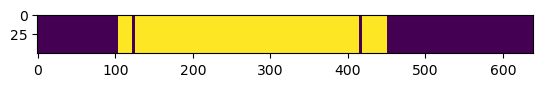

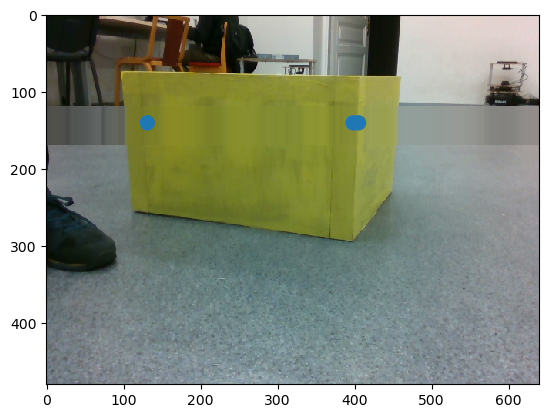

In [7]:
p = find_garage_points()

In [ ]:
k = [np.linalg.norm(point) for point in p]

In [ ]:
k

In [ ]:
p = Kuba2Basta(p)
p

In [ ]:
from numpy import array

points = [array([0.70712547, 0.1301093 ]),
 array([1.14586619, 1.43700976]),
 array([0.87538562, 1.79795419]),
 array([-0.50208621,  1.85321317])]
points = Basta2Kuba(points)

In [ ]:
points

In [ ]:
for p in points:
    print("DALSI BOD")
    turtle_controller.move_to(p)

In [ ]:
turtle_controller.move_to(p[1])

In [ ]:
import TurtleControllers

turtle = Turtlebot(rgb = True, pc = True, depth = False)
turtle_controller = TurtleControllers.TurtlebotController(turtle, rate = 40)
turtle_controller.reset_odometry()

In [ ]:
turtle_controller.move_to(np.array([0.2, 0]))

In [ ]:
img = turtle.get_rgb_image()

In [ ]:
plt.imshow(img)

In [ ]:
p

In [ ]:
p_basta = Kuba2Basta(p)

In [ ]:
p_basta

In [9]:
shorter_length = 0.45
longer_length = 0.59

def get_garage_model(points, shorter=shorter_length, longer=longer_length, max_error=0.15):
    points = [np.array(point) for point in points]
    distances = []
    for i in range(len(points)):
        for k in range(len(points)):
            if k <= i:
                continue
            distances.append([i, k, np.linalg.norm(points[i] - points[k])])

    longer_dist_points = min(distances, key=lambda x: abs(x[2] - longer))[:2]
    shorter_dist_points = min(distances, key=lambda x: abs(x[2] - shorter))[:2]

    print(longer_dist_points)
    print(shorter_dist_points)
    back_point_idx = (set(shorter_dist_points) & set(longer_dist_points)).pop()
    back_point = points[back_point_idx]
    longer_dist_points.remove(back_point_idx)
    shorter_dist_points.remove(back_point_idx)
    other_back_point = points[longer_dist_points[0]]
    front_point = points[shorter_dist_points[0]]
    
    print(front_point)
    print(other_back_point)
    print(back_point)

    backl, backr, frontl, frontr = [[0, 0], [0, 0], [0, 0], [0, 0]]

    if math.atan2(*other_back_point) < math.atan2(*front_point):
        #     |
        # ----|
        backl = other_back_point
        backr = back_point
        frontr = front_point
        frontl = backl + (frontr - backr)
    else:
        # |
        # |----
        backl = back_point
        backr = other_back_point
        frontl = front_point
        frontr = backr + (frontl - backl)

    return [backl, backr, frontr, frontl]

In [10]:
def get_target_points(garage_model, offset=1.0):
    """
    garage_model: [backl, backr, frontr, frontl]
    :param garage_model:
    :param offset:
    :return:
    """
    backl, backr, frontr, frontl = garage_model
    back = (backl + (backr - backl) / 2) + np.array([
        (backr - backl)[1],
        -(backr - backl)[0]
    ])*offset

    left_back = backl +  (backl - backr)*offset
    right_back = backr + (backr - backl)*offset
    left_front = frontl + (frontl - frontr)*offset
    right_front = frontr + (frontr - frontl)*offset

    front = (frontl + (frontr - frontl) / 2) + np.array([
        -(frontr - frontl)[1],
        (frontr - frontl)[0]
    ])*offset

    return [back, right_back, right_front, front, left_front, left_back]

In [ ]:
garage = get_garage_model(p_basta)

print(garage)

In [ ]:
pts = get_target_points(garage)

In [ ]:
pts

In [ ]:
kuba_pts = Basta2Kuba(pts)

In [ ]:
kuba_pts

In [ ]:
kuba_pts = list(reversed(kuba_pts[3:]))

In [ ]:
kuba_pts

In [ ]:
for p in kuba_pts:
    print("DALSI BOD")
    turtle_controller.move_to(p)

In [11]:
def visualize(ax, garage):
    
    ax.cla()
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    # TURTLEBOT
    circle1 = plt.Circle((0.0,0.0), 0.2, color='r')
    ax.add_patch(circle1)
    
#     for p in points:
#         circle2 = plt.Circle((-p[1], p[0]), 0.04, color='black')
#         ax.add_patch(circle2)
        
    for p in garage:
        circle2 = plt.Circle((-p[1], p[0]), 0.04, color='yellow')
        ax.add_patch(circle2)

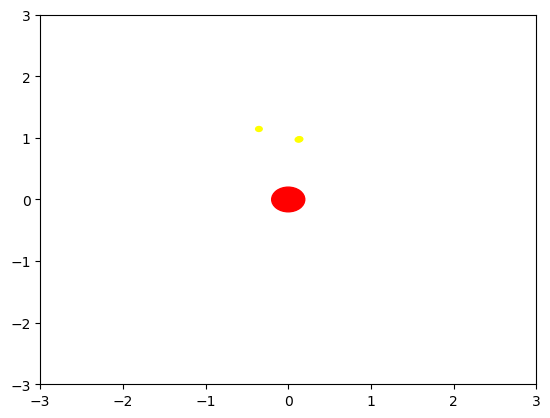

In [12]:
fig, ax = plt.subplots(1)
visualize(ax, p)

In [ ]:
np.linalg.norm(p[2] - p[0])

In [ ]:
get_garage_model(p)

In [ ]:
p

In [ ]:
turtle_controller.move_to(np.array([ 0.94247247 + 0.03, -0.06952666]))

/tmp/ipykernel_5073/4293055579.py:27: RuntimeWarning: Mean of empty slice
  distances = np.nanmean(img_depth_strip, axis = 0)


[0, 1]
[1, 2]
[0.37602574 1.23986867]
[-0.33528171  1.24708441]
[0.11137126 0.91806037]


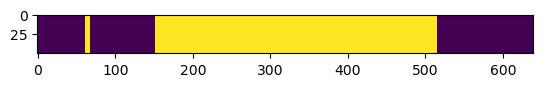

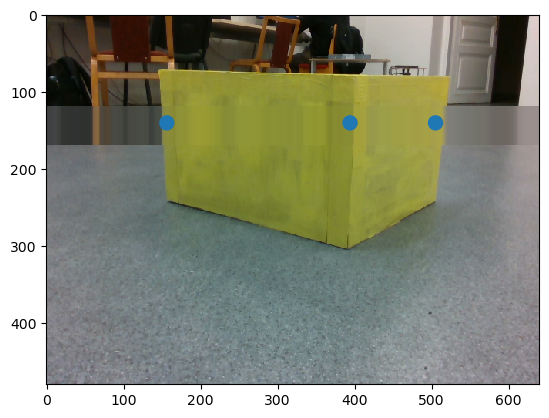

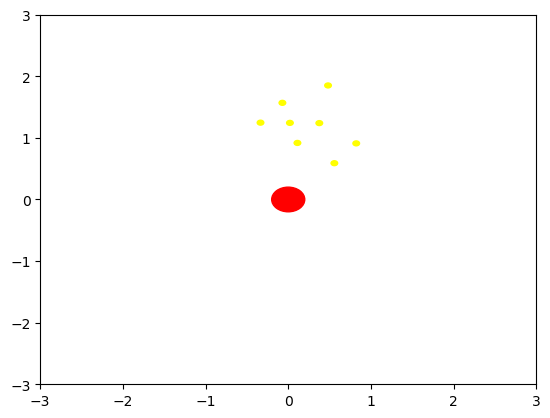

In [17]:
def p_mean(pts):
    p = np.array([0.,0.])
    for i in range(len(pts)):
        p += pts[i]
    return p / len(pts)

garage_points_kuba = find_garage_points()
garage_points_basta = Kuba2Basta(garage_points_kuba)

fig, ax = plt.subplots(1)

pts_basta = get_garage_model(garage_points_basta)
pts_basta2 = get_target_points(pts_basta)

pts_kuba = Basta2Kuba(pts_basta)
pts_kuba_target = Basta2Kuba(pts_basta2)
pt_mean = p_mean(pts_kuba)
visualize(ax, pts_kuba + [pt_mean] + pts_kuba_target[1:4])

In [18]:
import TurtleControllers

turtle = Turtlebot(rgb = True, pc = True, depth = False)
turtle_controller = TurtleControllers.TurtlebotController(turtle, rate = 40)

for p in pts_kuba_target[1:4] + [pt_mean]:
    turtle_controller.move_to(p)

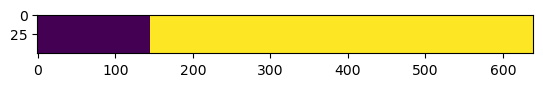

In [48]:
def get_garage_mask(img, color = "PURPLE"):
    img_strip = flatten(img)
    hsv = cv2.cvtColor(img_strip, cv2.COLOR_RGB2HSV)
    # PURPLE
    
    if color == "PURPLE":
        lower_color = np.array([115, 0, 0])
        upper_color = np.array([140, 250, 250])
    elif color == "YELLOW":
        lower_color = np.array([8, 120, 100])
        upper_color = np.array([50, 240, 200])
        
    mask = cv2.inRange(hsv, lower_color, upper_color)
    mask = mask / np.max(mask)
    return mask

img_rgb = turtle.get_rgb_image()
permute_rgb(img_rgb)
mask = get_garage_mask(img_rgb, color = "YELLOW")

plt.imshow(mask)

In [ ]:
print(img_)